In [103]:
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy.stats import norm

import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [104]:
data = pd.read_excel('AB_Test_Results.xlsx')

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [106]:
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00


In [107]:
data.shape

(10000, 3)

In [108]:
data.describe()

,USER_ID,REVENUE
count,"10,000.00","10,000.00"
mean,"4,981.08",0.10
std,"2,890.59",2.32
min,2.00,0.00
25%,"2,468.75",0.00
50%,"4,962.00",0.00
75%,"7,511.50",0.00
max,"10,000.00",196.01


In [109]:
data.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [110]:
data.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [111]:
new_data = data[data['REVENUE'] > 0]
new_data

,USER_ID,VARIANT_NAME,REVENUE
13,2529,variant,2.15
49,6429,control,3.25
139,3331,variant,4.27
149,8110,variant,1.75
152,8607,control,2.99
...,...,...,...
9651,9928,variant,1.25
9711,6468,control,2.93
9724,5205,control,14.17
9725,702,variant,2.92


Данные распределены примерно поровну 5016-4984. Пустых данных и отрицательных значений выручки REVENUE в наборе данных нет, т.е. ошибочных значений в этом поле нет.

In [112]:
new_data[data['VARIANT_NAME']=='variant'].describe()

,USER_ID,REVENUE
count,72.00,72.00
mean,"5,306.96",4.88
std,"3,116.54",9.91
min,56.00,0.02
25%,"2,707.50",1.25
50%,"5,721.00",2.17
75%,"7,963.75",3.97
max,"9,996.00",58.63


In [113]:
new_data[data['VARIANT_NAME']=='control'].describe()

,USER_ID,REVENUE
count,80.00,80.00
mean,"4,461.95",8.04
std,"2,826.39",22.50
min,124.00,0.02
25%,"2,037.50",1.52
50%,"4,327.00",2.96
75%,"6,636.75",6.66
max,"9,766.00",196.01


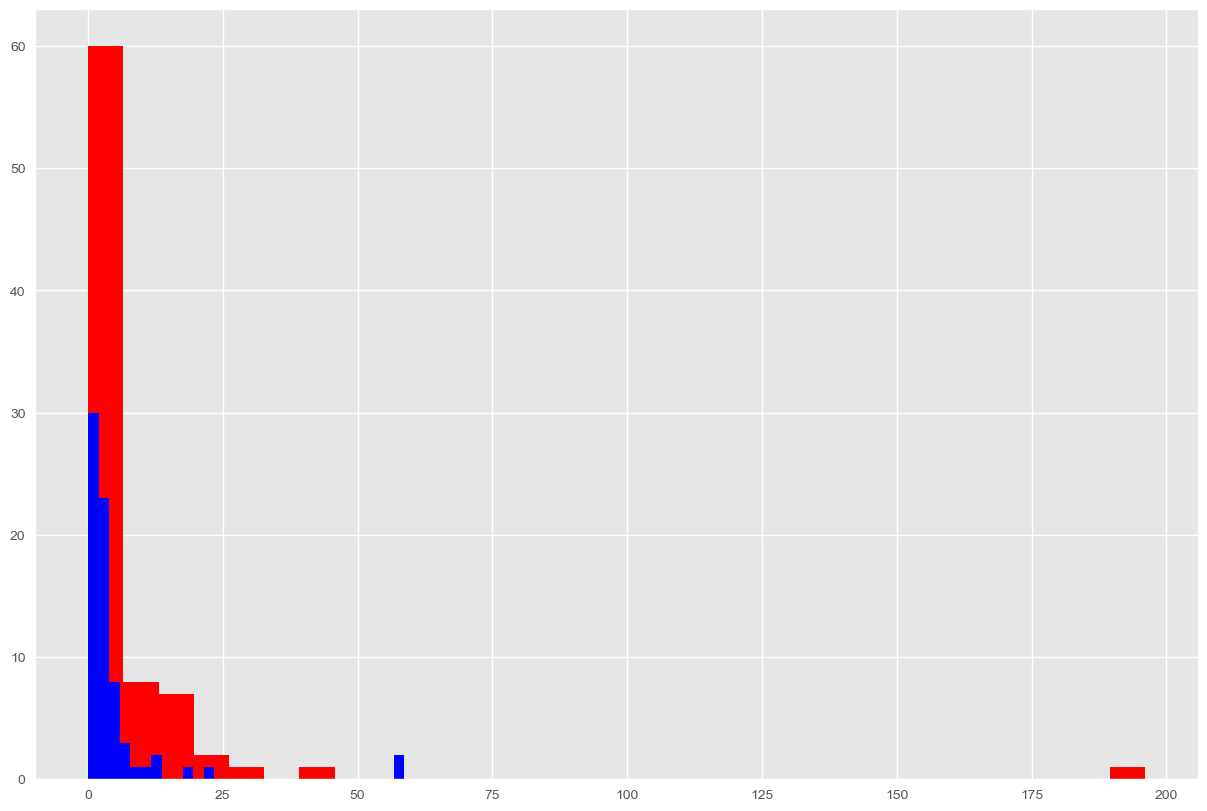

In [114]:
plt.figure(figsize=(15, 10))
control_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='control']
test_visit_all = new_data['REVENUE'][data['VARIANT_NAME']=='variant']

plt.hist(control_visit_all, color='r', bins=30)
plt.hist(test_visit_all, color='b', bins=30)

plt.show()

In [115]:
ttest_ind(control_visit_all, test_visit_all, equal_var = False)

Ttest_indResult(statistic=1.1379124979933528, pvalue=0.25760685398932337)

Т.к. pvalue > 0.05, то статистически значимых различий выявлено

In [116]:
mannwhitneyu(control_visit_all, test_visit_all)

MannwhitneyuResult(statistic=3356.0, pvalue=0.07924299810603061)

Так как pvalue > 0.05 принимается нулевая гипотеза, т.е. статистически значимых различий выявлено

In [117]:
kstest(control_visit_all, 'norm')

KstestResult(statistic=0.7443502263331446, pvalue=3.4769340937348253e-46, statistic_location=1.25, statistic_sign=-1)

In [118]:
kstest(test_visit_all, 'norm')

KstestResult(statistic=0.6885669682907651, pvalue=1.5788521734348758e-34, statistic_location=1.0, statistic_sign=-1)

pvalue < 0.05, следовательно нулевая гипотеза отвергается. Ненормальное распределение данных

In [119]:
def get_bootstrap(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(boot_len, replace = True).values       
        samples_2 = data_column_2.sample(boot_len, replace = True).values
        boot_data.append(statistic(samples_1)-statistic(samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('lightgrey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=200,linestyle='-', color = 'b')
    plt.xlabel('Значение метрики')
    plt.ylabel('Частота')
    plt.title("Гистограмма распределения")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

In [120]:
def bootstrap(data, func):
    boots = np.random.choice(data, len(data))
    return func(boots)

def bootstrapping(data, func=np.mean, size=1):
    reps = np.empty(size)
    for i in range(size):
        reps[i] = bootstrap(data, func)
    return reps

100%|██████████| 10000/10000 [00:04<00:00, 2205.33it/s]


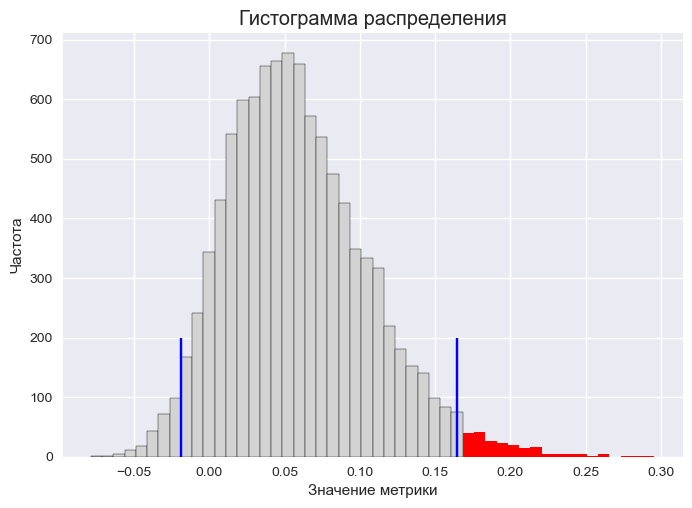

p_value 0.2099248089278548


In [121]:
plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:,.2f}'.format

booted_data = get_bootstrap(data['REVENUE'][data['VARIANT_NAME']=='control'],
                            data['REVENUE'][data['VARIANT_NAME']=='variant'],
                            boot_it = 10000)

print('p_value', booted_data['p_value'])

In [ ]:
Так как p_value > 0.05 статистически значимых различий выявлено. Не отвергаем нулевую гипотезу, оставляем контрольную версию. 
